## Table of contents :
* [I - Evaluation](#first)
    * [1 - Training results (target : 'SiteEnergyUse(kBtu)')](#first_1)
    * [2 - Training results (target : 'TotalGHGEmissions')](#first_2)
* [II - Final models](#second)
    * [1 - Target : 'SiteEnergyUse(kBtu)'](#second_1)
    * [2 - Target : 'TotalGHGEmissions'](#second_2)
* [III - Conclusion](#third)

In [1]:
# Import custom packages & modules
import sys
sys.path.append("..")
# Univariate analysis module
from src.analyzer.univariate import *
# Multivariate analysis module
from src.analyzer.multivariate import *
# Data cleaning module
from src.datacleaner import *
# Data preprocessing module
from src.preprocessor import *
# Model evaluation module
from src.evaluator import *
# Ensemble-based methods
import xgboost as xgb

# I - Evaluation <a class="anchor" id="first"></a>

- We finish the modeling work by comparing the different results obtained according to the **inclusion**
or the **exclusion** of the variables : 
    - **ENERGYSTARScore**
    - **Main_energy_electricity & Main_energy_steam**.
- We are particularly interested here in the **difference in RMSE values** according to models & datasets

In [2]:
# Results with ENERGYSTARScore variable
results_data_ess_energy_vars = pickle_data(filename='main_results_ENERGYSTARScore',
                                           folder='../data/pkl',
                                           method='r')

# Results without ENERGYSTARScore variable
results_data_energy_vars = pickle_data(filename='main_results_no_ENERGYSTARScore',
                                       folder='../data/pkl',
                                       method='r')

# Results without ENERGYSTARScore, Main_energy_electricity, Main_energy_steam variables
results_data_no_energy_vars = pickle_data(filename='main_results_no_ENERGYSTARScore_no_main_energy_vars',
                                          folder='../data/pkl',
                                          method='r')

In [3]:
# Target tags
target_tags = ['en', 'em']
# Results dataframe without ENERGYSTARScore variable
en_results_ess, em_results_ess = [results_data_ess_energy_vars[f'{t}'][f'{t}_results_df'] for t in target_tags]
# Results dataframe without ENERGYSTARScore variable
en_results, em_results = [results_data_energy_vars[f'{t}'][f'{t}_results_df'] for t in target_tags]
# Results dataframe without ENERGYSTARScore, Main_energy_electricity, Main_energy_steam variables
en_results_no_en, em_results_no_en = [results_data_no_energy_vars[f'{t}'][f'{t}_results_df'] for t in target_tags]

In [4]:
# Format run time for each result dataframes (e.g : "1 min 10s" --> "00:01:10")
dfs = [en_results, em_results, en_results_no_en, em_results_no_en]
for df in dfs: convert_str_time_to_time(df)

## 1 - Training results (target : 'SiteEnergyUse(kBtu)') <a class="anchor" id="first_1"></a>

#### 1.1 - Include/exclude ENERGYSTARScore

In [5]:
# Results dataframe with ENERGYSTARScore variable and with Main_energy_electricity, Main_energy_steam variables
en_results_ess

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.361,0.900,,29,No
1,RandomForestRegressor,0.371,0.894,7 s,7,Yes
2,XGBRegressor,0.359,0.901,9 s,7,Yes
3,SVR,0.466,0.833,4 s,7,No
4,MLPRegressor,0.466,0.833,2 min 23 s,7,No


In [6]:
# Results dataframe without ENERGYSTARScore variable and with Main_energy_electricity, Main_energy_steam variables
en_results

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.536,0.774,00:00:01,34,No
1,RandomForestRegressor,0.470,0.826,00:00:35,13,Yes
2,XGBRegressor,0.442,0.846,00:00:11,13,Yes
3,SVR,0.565,0.749,00:00:09,13,No
4,MLPRegressor,0.572,0.743,00:03:51,13,Yes


In [7]:
# Build target final training results
def target_results(target_df1, target_df2, key_join='Model', var_type='Main_energy_variables'):
    # Merge results dataframes in order to compare model scores
    target_df = target_df1.merge(target_df2, on=key_join,
                                 suffixes=(f'_include_{var_type}',
                                           f'_exclude_{var_type}'))
    # Pandas dataframe styling
    include_color = "background: lightgreen"
    exclude_color = "background: salmon"
    bold = 'font-weight: bold'
    # Condition for assigning a color according to the inclusion or exclusion of energy variables
    color_cond = lambda x: [include_color if 'include' in x.name else exclude_color for v in x]
    # Condition to display in bold the minimum values of each line
    min_val_cond = lambda x, v: ((v == x.min() and v != 'No' and 'R2' not in x.name) | (v == 'Yes'))
    # Condition to display in bold the maximum R2 values of each line
    max_r2_cond = lambda x, v: ('R2' in x.name and v == x.max())
    # Condition to display the best values of the results
    best_val_cond = lambda x: [bold if max_r2_cond(x, v) | min_val_cond(x, v)  else '' for v in x]
    # Transpose comparator dataframe & rename index as 'Variable\Model'
    target_df_T = target_df.set_index(key_join).T.rename_axis(f'Variable\{key_join}', axis=1)
    # Apply styling conditions
    target_df_T_colored = target_df_T.style.apply(color_cond, axis=1).apply(best_val_cond, axis=1)
    return target_df_T, target_df_T_colored

def target_score_results(target_results_df, score='RMSE'):
    # Scope score (default = RMSE)
    en_rmse_comparator = target_results_df.filter(like=score, axis=0)
    # Get model labels
    models = en_rmse_comparator.columns
    # Compute percentage change between RMSE which included or excluded energy variables
    en_score_gap = [percentage_change(s_inc, s_exc) for s_inc, s_exc in zip(*en_rmse_comparator.values)]
    # Build Score gap row
    en_score_gap_serie = pd.Series({col: v for col,v in zip(models, en_score_gap)}, name='Score_difference (%)')
    # Add Score gap row to rmse comparator dataframe
    en_rmse_comparator = en_rmse_comparator.append(en_score_gap_serie)
    # If Score_gap value is positive then it increases model score else it decreases model score
    # (main model considered here include main energy variables)
    return en_rmse_comparator

In [8]:
energy_results_ess, energy_results_ess_colored = target_results(en_results_ess,
                                                                en_results,
                                                                var_type='ENERGYSTARScore')
energy_results_ess_colored
# Included main energy variables values are in green, excluded are in red
# Best values are in bold (e.g : the largest R2 and the lowest RMSE for each row)

Variable\Model,ElasticNetCV,RandomForestRegressor,XGBRegressor,SVR,MLPRegressor
RMSE_include_ENERGYSTARScore,0.361000,0.371000,0.359000,0.466000,0.466000
R2_include_ENERGYSTARScore,0.900000,0.894000,0.901000,0.833000,0.833000
Run time_include_ENERGYSTARScore,,7 s,9 s,4 s,2 min 23 s
Selected features_include_ENERGYSTARScore,29,7,7,7,7
Learning potential_include_ENERGYSTARScore,No,Yes,Yes,No,No
RMSE_exclude_ENERGYSTARScore,0.536000,0.470000,0.442000,0.565000,0.572000
R2_exclude_ENERGYSTARScore,0.774000,0.826000,0.846000,0.749000,0.743000
Run time_exclude_ENERGYSTARScore,00:00:01,00:00:35,00:00:11,00:00:09,00:03:51
Selected features_exclude_ENERGYSTARScore,34,13,13,13,13
Learning potential_exclude_ENERGYSTARScore,No,Yes,Yes,No,Yes


In [9]:
energy_rmse_ess_results = target_score_results(energy_results_ess, score='RMSE')
energy_rmse_ess_results

Variable\Model,ElasticNetCV,RandomForestRegressor,XGBRegressor,SVR,MLPRegressor
RMSE_include_ENERGYSTARScore,0.361,0.371,0.359,0.466,0.466
RMSE_exclude_ENERGYSTARScore,0.536,0.47,0.442,0.565,0.572
Score_difference (%),48.48,26.68,23.12,21.24,22.75


#### 1.2 - Include/exclude Main_energy_electricity, Main_energy_steam variables

In [10]:
# Results dataframe without ENERGYSTARScore variable and with Main_energy_electricity, Main_energy_steam variables
en_results

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.536,0.774,00:00:01,34,No
1,RandomForestRegressor,0.470,0.826,00:00:35,13,Yes
2,XGBRegressor,0.442,0.846,00:00:11,13,Yes
3,SVR,0.565,0.749,00:00:09,13,No
4,MLPRegressor,0.572,0.743,00:03:51,13,Yes


In [11]:
# Results dataframe without ENERGYSTARScore, Main_energy_electricity, Main_energy_steam variables
en_results_no_en

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.559,0.754,00:00:01,31,No
1,RandomForestRegressor,0.480,0.818,00:00:09,12,Yes
2,XGBRegressor,0.451,0.840,00:00:11,12,Yes
3,SVR,0.589,0.727,00:00:09,12,No
4,MLPRegressor,0.593,0.723,00:03:20,12,No


In [12]:
# Build target final training results
energy_results, energy_results_colored = target_results(en_results,
                                                        en_results_no_en,
                                                        var_type='Main_energy_variables')
energy_results_colored

Variable\Model,ElasticNetCV,RandomForestRegressor,XGBRegressor,SVR,MLPRegressor
RMSE_include_Main_energy_variables,0.536000,0.470000,0.442000,0.565000,0.572000
R2_include_Main_energy_variables,0.774000,0.826000,0.846000,0.749000,0.743000
Run time_include_Main_energy_variables,00:00:01,00:00:35,00:00:11,00:00:09,00:03:51
Selected features_include_Main_energy_variables,34,13,13,13,13
Learning potential_include_Main_energy_variables,No,Yes,Yes,No,Yes
RMSE_exclude_Main_energy_variables,0.559000,0.480000,0.451000,0.589000,0.593000
R2_exclude_Main_energy_variables,0.754000,0.818000,0.840000,0.727000,0.723000
Run time_exclude_Main_energy_variables,00:00:01,00:00:09,00:00:11,00:00:09,00:03:20
Selected features_exclude_Main_energy_variables,31,12,12,12,12
Learning potential_exclude_Main_energy_variables,No,Yes,Yes,No,No


In [13]:
energy_rmse_results = target_score_results(energy_results, score='RMSE')
energy_rmse_results
# Adding main energy variables improve best model (XGBRegressor) RMSE score by almost 2%

Variable\Model,ElasticNetCV,RandomForestRegressor,XGBRegressor,SVR,MLPRegressor
RMSE_include_Main_energy_variables,0.536,0.47,0.442,0.565,0.572
RMSE_exclude_Main_energy_variables,0.559,0.48,0.451,0.589,0.593
Score_difference (%),4.29,2.13,2.04,4.25,3.67


## 2 - Training results ( target : 'TotalGHGEmissions' ) <a class="anchor" id="first_2"></a>

#### 2.1 - Include/exclude ENERGYSTARScore

In [14]:
# Results dataframe with ENERGYSTARScore variable and with Main_energy_electricity, Main_energy_steam variables
em_results_ess

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.364,0.898,,28,No
1,RandomForestRegressor,0.365,0.897,9 s,8,Yes
2,XGBRegressor,0.374,0.892,6 s,8,Yes
3,SVR,0.368,0.896,7 s,32,No
4,MLPRegressor,0.463,0.835,45 s,8,Yes


In [15]:
# Results dataframe without ENERGYSTARScore variable and with Main_energy_electricity, Main_energy_steam variables
em_results

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.543,0.767,00:00:01,35,No
1,RandomForestRegressor,0.471,0.826,00:00:31,13,Yes
2,XGBRegressor,0.461,0.833,00:00:10,13,Yes
3,SVR,0.566,0.748,00:00:10,13,No
4,MLPRegressor,0.572,0.742,00:02:05,13,No


In [16]:
emissions_results_ess, emissions_results_ess_colored = target_results(em_results_ess,
                                                                      em_results,
                                                                      var_type='ENERGYSTARScore')
emissions_results_ess_colored

Variable\Model,ElasticNetCV,RandomForestRegressor,XGBRegressor,SVR,MLPRegressor
RMSE_include_ENERGYSTARScore,0.364000,0.365000,0.374000,0.368000,0.463000
R2_include_ENERGYSTARScore,0.898000,0.897000,0.892000,0.896000,0.835000
Run time_include_ENERGYSTARScore,,9 s,6 s,7 s,45 s
Selected features_include_ENERGYSTARScore,28,8,8,32,8
Learning potential_include_ENERGYSTARScore,No,Yes,Yes,No,Yes
RMSE_exclude_ENERGYSTARScore,0.543000,0.471000,0.461000,0.566000,0.572000
R2_exclude_ENERGYSTARScore,0.767000,0.826000,0.833000,0.748000,0.742000
Run time_exclude_ENERGYSTARScore,00:00:01,00:00:31,00:00:10,00:00:10,00:02:05
Selected features_exclude_ENERGYSTARScore,35,13,13,13,13
Learning potential_exclude_ENERGYSTARScore,No,Yes,Yes,No,No


In [17]:
emissions_rmse_ess_results = target_score_results(emissions_results_ess, score='RMSE')
emissions_rmse_ess_results

Variable\Model,ElasticNetCV,RandomForestRegressor,XGBRegressor,SVR,MLPRegressor
RMSE_include_ENERGYSTARScore,0.364,0.365,0.374,0.368,0.463
RMSE_exclude_ENERGYSTARScore,0.543,0.471,0.461,0.566,0.572
Score_difference (%),49.18,29.04,23.26,53.8,23.54


#### 2.2 - Include/exclude Main_energy_electricity, Main_energy_steam variables

In [18]:
# Results dataframe without ENERGYSTARScore variable and with Main_energy_electricity, Main_energy_steam variables
em_results

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.543,0.767,00:00:01,35,No
1,RandomForestRegressor,0.471,0.826,00:00:31,13,Yes
2,XGBRegressor,0.461,0.833,00:00:10,13,Yes
3,SVR,0.566,0.748,00:00:10,13,No
4,MLPRegressor,0.572,0.742,00:02:05,13,No


In [19]:
# Results dataframe without ENERGYSTARScore, Main_energy_electricity, Main_energy_steam variables
em_results_no_en

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.572,0.743,00:00:01,36,No
1,RandomForestRegressor,0.474,0.823,00:00:16,18,Yes
2,XGBRegressor,0.458,0.835,00:00:25,18,Yes
3,SVR,0.572,0.742,00:00:11,18,No
4,MLPRegressor,0.580,0.735,00:01:28,18,Yes


In [20]:
# Build target final training results
emissions_results, emissions_results_colored = target_results(em_results, em_results_no_en)
emissions_results_colored

Variable\Model,ElasticNetCV,RandomForestRegressor,XGBRegressor,SVR,MLPRegressor
RMSE_include_Main_energy_variables,0.543000,0.471000,0.461000,0.566000,0.572000
R2_include_Main_energy_variables,0.767000,0.826000,0.833000,0.748000,0.742000
Run time_include_Main_energy_variables,00:00:01,00:00:31,00:00:10,00:00:10,00:02:05
Selected features_include_Main_energy_variables,35,13,13,13,13
Learning potential_include_Main_energy_variables,No,Yes,Yes,No,No
RMSE_exclude_Main_energy_variables,0.572000,0.474000,0.458000,0.572000,0.580000
R2_exclude_Main_energy_variables,0.743000,0.823000,0.835000,0.742000,0.735000
Run time_exclude_Main_energy_variables,00:00:01,00:00:16,00:00:25,00:00:11,00:01:28
Selected features_exclude_Main_energy_variables,36,18,18,18,18
Learning potential_exclude_Main_energy_variables,No,Yes,Yes,No,Yes


In [21]:
emissions_rmse_results = target_score_results(emissions_results, score='RMSE')
emissions_rmse_results
# Adding main energy variables regress best model (XGBRegressor) RMSE score by 0.65%

Variable\Model,ElasticNetCV,RandomForestRegressor,XGBRegressor,SVR,MLPRegressor
RMSE_include_Main_energy_variables,0.543,0.471,0.461,0.566,0.572
RMSE_exclude_Main_energy_variables,0.572,0.474,0.458,0.572,0.58
Score_difference (%),5.34,0.64,-0.65,1.06,1.4


**Conclusion :**

**1 - Keeping ENERGYSTARScore :**
- **improve** best model (XGBRegressor) RMSE score by **23.12%** concerning energy target
- **improve** best model (XGBRegressor) RMSE score by **23.26%** concerning emissions target

Decision : **keep the model which excludes ENERGYSTARScore variable** because acquiring this data is costly

**2 - Keeping main energy variables :**
- **improve** best model (XGBRegressor) RMSE score by **2.04%** concerning energy target
- **regress** best model (XGBRegressor) RMSE score by **0.65%** concerning emissions target

Decision : **keep the model which excludes the energy variables** because 
the performance gain remains low compared to the cost of acquiring energy variables

# II - Final models  <a class="anchor" id="second"></a>

## 1 - Target : 'SiteEnergyUse(kBtu)' <a class="anchor" id="second_1"></a>

In [22]:
# Final model results for energy target
en_res = results_data_no_energy_vars['en']['en_results_df']
en_res

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.559,0.754,00:00:01,31,No
1,RandomForestRegressor,0.480,0.818,00:00:09,12,Yes
2,XGBRegressor,0.451,0.840,00:00:11,12,Yes
3,SVR,0.589,0.727,00:00:09,12,No
4,MLPRegressor,0.593,0.723,00:03:20,12,No


In [23]:
en_res.loc[en_res['RMSE'].idxmin()].to_frame().T

,Model,RMSE,R2,Run time,Selected features,Learning potential
2,XGBRegressor,0.451,0.84,00:00:11,12,Yes


In [24]:
# Model features
results_data_no_energy_vars['en']['en_best_features']

['PropertyGFATotal',
 'North_south_dist',
 'East_west_dist',
 'PrimaryPropertyType_Supermarket/GroceryStore',
 'SecondLargestPropertyUseTypeGFA',
 'PrimaryPropertyType_Other',
 'BuildingType_Multifamily LR (1-4)',
 'BuildingType_Multifamily MR (5-9)',
 'PrimaryPropertyType_Self-StorageFacility',
 'PrimaryPropertyType_Warehouse',
 'PrimaryPropertyType_Non-RefrigeratedWarehouse',
 'Neighborhood_Downtown']

In [25]:
# "North_south_dist" --> (built from) Latitude
# "East_west_dist" --> (built from) Longitude

selected_features_energy_target = ['PropertyGFATotal',
                                   'Latitude',
                                   'Longitude',
                                   'PrimaryPropertyType',
                                   'SecondLargestPropertyUseTypeGFA',
                                   'BuildingType',
                                   'Neighborhood']

print(f"Total of variables required from original dataset : {len(selected_features_energy_target)}")

Total of variables required from original dataset : 7


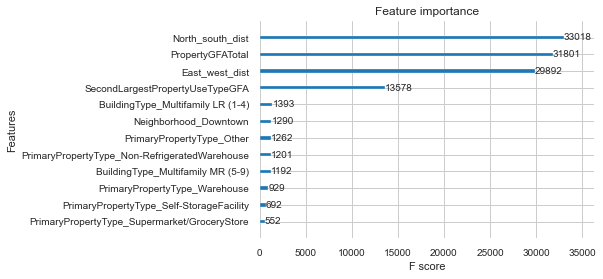

In [26]:
# Plot feature importance from best model 
xgb.plot_importance(results_data_no_energy_vars['en']['en_best_model']['model'])

#### Evaluate feature importance distribution

In [27]:
# Get feature importance coefficients
xgbr_en_model = results_data_no_energy_vars['en']['en_best_model']['model']
xgbr_en_fimp_dict = xgbr_en_model.get_booster().get_score(importance_type="weight")
# Sort dict
xgbr_en_feature_importance_dict = dict(sorted(xgbr_en_fimp_dict.items(), key=lambda item: item[1], reverse=True))

In [28]:
# Sum lowest feature coefficients
last_8_variables_sum = sum(list(xgbr_en_feature_importance_dict.values())[4:])
# Check lowest feature coefficients ratio compared to the fourth most important variable
last_8_variables_sum / 13578
# Last 8 variables coefficients represent 62 % of the fourth most important variable

0.6268228015908086

It seems that **most needed variables** are :
- **PropertyGFATotal**,
- **Latitude**,
- **Longitude**,
- **SecondLargestPropertyUseTypeGFA**

#### Train XGBoost regressor with the fourth most important features

In [29]:
# Train XGBoost with these 4 main features

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Import du dataset
df= pd.read_csv('../data/csv/seattle_model_data_no_ENERGYSTARScore.csv')

# Targets
targets_cols = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

# Features
features_cols = list(xgbr_en_feature_importance_dict.keys())[:4]

# Features data
X = df[features_cols]

# Targets data
y = df[targets_cols]

# Training & testing sets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split targets (energy consumption & gaz emissions features)
y_train_energy, y_train_emissions = [y_train[target] for target in targets_cols]
y_test_energy, y_test_emissions = [y_test[target] for target in targets_cols]

# Standardize data (center & reduce)
X_train_std, std_scaler = standard_scaler(X_train, return_std_scaler=True)
X_test_std = std_scaler.transform(X_test)

In [30]:
# Select best (hyper)parameters from best XGBoost regression model
xgbr_en_best_params = xgbr_en_model.get_xgb_params()
# Build another model
xgbr_en_reduced_model = xgb.XGBRegressor(**xgbr_en_best_params)
# Train model with cross validation (k = 10)
en_scores = cross_validate(xgbr_en_reduced_model,
                           X_train_std,
                           y_train_energy,
                           cv=10,
                           scoring='neg_root_mean_squared_error')
# Compute mean RMSE from testing set
en_testing_set_rmse = round(np.abs(en_scores['test_score']).mean(), 3)
print(f'Testing set RMSE = {en_testing_set_rmse}')

Testing set RMSE = 0.658


In [31]:
# Compute RMSE percentage change between optimal and reduced models
en_optimal_model_rmse = en_res.loc[en_res['RMSE'].idxmin()].to_frame().T['RMSE'].tolist()[0]
rmse_difference = percentage_change(en_testing_set_rmse, en_optimal_model_rmse)
print(f'RMSE difference between optimal model and reduced model = {rmse_difference} %')
# It seems that reduced model with 4 features is almost 31% worst than optimal model with 11 features

RMSE difference between optimal model and reduced model = -31.46 %


## 2 - Target : 'TotalGHGEmissions' <a class="anchor" id="second_2"></a>

In [32]:
# Final model results for emissions target
em_res = results_data_no_energy_vars['em']['em_results_df']
em_res

,Model,RMSE,R2,Run time,Selected features,Learning potential
0,ElasticNetCV,0.572,0.743,00:00:01,36,No
1,RandomForestRegressor,0.474,0.823,00:00:16,18,Yes
2,XGBRegressor,0.458,0.835,00:00:25,18,Yes
3,SVR,0.572,0.742,00:00:11,18,No
4,MLPRegressor,0.580,0.735,00:01:28,18,Yes


In [33]:
em_res.loc[em_res['RMSE'].idxmin()].to_frame().T

,Model,RMSE,R2,Run time,Selected features,Learning potential
2,XGBRegressor,0.458,0.835,00:00:25,18,Yes


In [34]:
# Model features
results_data_no_energy_vars['em']['em_best_features']

['PropertyGFATotal',
 'North_south_dist',
 'East_west_dist',
 'BuildingType_Multifamily LR (1-4)',
 'SecondLargestPropertyUseTypeGFA',
 'PrimaryPropertyType_Supermarket/GroceryStore',
 'PrimaryPropertyType_Other',
 'PrimaryPropertyType_Hotel',
 'BuildingType_Multifamily MR (5-9)',
 'OldBuilding',
 'PrimaryPropertyType_Self-StorageFacility',
 'Neighborhood_East',
 'PrimaryPropertyType_Warehouse',
 'PrimaryPropertyType_SeniorCareCommunity',
 'PrimaryPropertyType_Non-RefrigeratedWarehouse',
 'Neighborhood_Downtown',
 'PrimaryPropertyType_LargeOffice',
 'PrimaryPropertyType_Restaurant']

In [35]:
# "North_south_dist" --> (built from) Latitude
# "East_west_dist" --> (built from) Longitude
# "OldBuilding" --> (built from) YearBuilt

selected_features_emissions_target = ['PropertyGFATotal',
                                      'Latitude',
                                      'Longitude',
                                      'PrimaryPropertyType',
                                      'SecondLargestPropertyUseTypeGFA',
                                      'BuildingType',
                                      'YearBuilt',
                                      'Neighborhood']

print(f"Total of variables required from original dataset : {len(selected_features_emissions_target)}")

Total of variables required from original dataset : 8


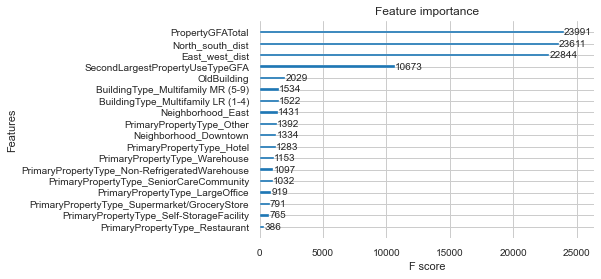

In [36]:
# Plot feature importance from best model 
xgb.plot_importance(results_data_no_energy_vars['em']['em_best_model']['model'])

#### Evaluate feature importance distribution

In [37]:
# Get feature importance coefficients
xgbr_em_model = results_data_no_energy_vars['em']['em_best_model']['model']
xgbr_em_fimp_dict = xgbr_em_model.get_booster().get_score(importance_type="weight")
# Sort dict
xgbr_em_feature_importance_dict = dict(sorted(xgbr_em_fimp_dict.items(), key=lambda item: item[1], reverse=True))

In [38]:
# Sum lowest feature coefficients
last_14_variables_sum = sum(list(xgbr_en_feature_importance_dict.values())[4:])
# Check lowest feature coefficients ratio compared to the fourth most important variable
last_14_variables_sum / 10673
# Last 14 variables coefficients represent almost 80 % of the fourth most important variable

0.7974327742902652

It seems that **most needed variables** are also :
- **PropertyGFATotal**,
- **Latitude**,
- **Longitude**,
- **SecondLargestPropertyUseTypeGFA**

#### Train XGBoost regressor with the fourth most important features

In [39]:
# Select best (hyper)parameters from best XGBoost regression model
xgbr_em_best_params = xgbr_em_model.get_xgb_params()
# Build another model
xgbr_em_reduced_model = xgb.XGBRegressor(**xgbr_em_best_params)
# Train model with cross validation (k = 10)
em_scores = cross_validate(xgbr_em_reduced_model,
                           X_train_std,
                           y_train_energy,
                           cv=10,
                           scoring='neg_root_mean_squared_error')
# Compute mean RMSE from testing set
em_testing_set_rmse = round(np.abs(em_scores['test_score']).mean(), 3)
print(f'Testing set RMSE = {em_testing_set_rmse}')

Testing set RMSE = 0.698


In [40]:
# Compute RMSE percentage change between optimal and reduced models
em_optimal_model_rmse = em_res.loc[em_res['RMSE'].idxmin()].to_frame().T['RMSE'].tolist()[0]
rmse_difference = percentage_change(em_testing_set_rmse, em_optimal_model_rmse)
print(f'RMSE difference between optimal model and reduced model = {rmse_difference} %')
# It seems that reduced model with 4 features is around 34% worst than optimal model with 18 features

RMSE difference between optimal model and reduced model = -34.38 %


# III - Conclusion : <a class="anchor" id="third"></a>

**Model :**
   - The best model is **XGBoost** and it relates to **both targets**
   
**Feature selection :**
   - **Energy target** require **7 features** from the original dataset
   - **Emissions target** require **another feature** from the original dataset compared to energy target which is **YearBuilt**
   - Among these 7/8 features, **4 of them represent around 70% of model's performance** which are :
        - **PropertyGFATotal**,
        - **Latitude**,
        - **Longitude**,
        - **SecondLargestPropertyUseTypeGFA**

**N.B :**
   - If necessary, the variables relating to the geographic position (Latitude, Longitude) of a building can be **extrapolated from its address** (geocoding in python)